In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

In [2]:
def read_data(path,**kwargs):
    df=pd.DataFrame()
    try:
        df=pd.read_csv(path,**kwargs)
    except FileNotFoundError:
        print(f"File {path} not found")
    except Exception as e:
        print(f"An error occured: {e}")
    return df

In [22]:
train=read_data('../data/plain/train.csv')
test=read_data('../data/plain/test.csv')

In [23]:
train.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [5]:
train.shape

(2190, 13)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB


In [7]:
def day_to_month(day):
        """Converts day of the year to month."""
        if 1 <= day <= 31:
           return 1  # January
        elif 32 <= day <= 59:
            return 2  # February (non-leap year)
        elif 60 <= day <= 90:
            return 3  # March
        elif 91 <= day <= 120:
            return 4  # April
        elif 121 <= day <= 151:
            return 5  # May
        elif 152 <= day <= 181:
            return 6  # June
        elif 182 <= day <= 212:
            return 7  # July
        elif 213 <= day <= 243:
            return 8  # August
        elif 244 <= day <= 273:
            return 9  # September
        elif 274 <= day <= 304:
            return 10 # October
        elif 305 <= day <= 334:
            return 11 # November
        else:
            return 12   # December


In [8]:
def extract_temporal_features(df):
    df['week_of_year'] = ((df['day'] - 1) // 7) + 1
    df['month'] = df['day'].apply(day_to_month)
    df['day_of_week'] = (df['day'] - 1) % 7
    return df

In [24]:
train = extract_temporal_features(train)
test = extract_temporal_features(test)

In [25]:
train.to_csv('../data/plain/train_temporal.csv',index=False)
test.to_csv('../data/plain/test_temporal.csv',index=False)

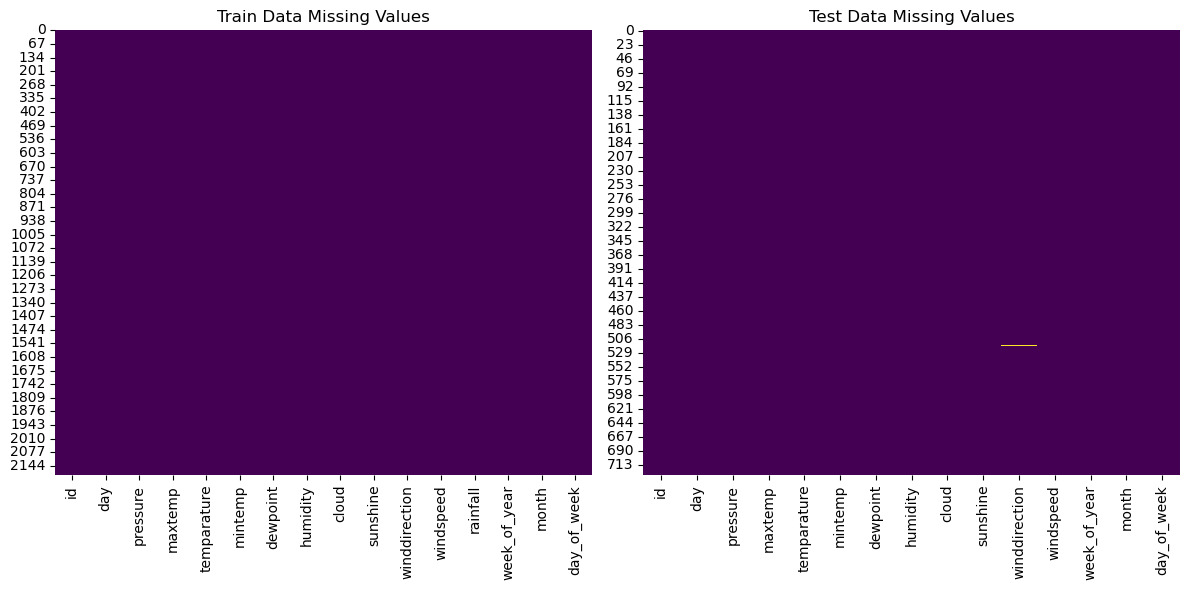

In [10]:
# Create missing values heatmaps
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
plt.title('Train Data Missing Values')

plt.subplot(1, 2, 2)
sns.heatmap(test.isnull(), cbar=False, cmap='viridis')
plt.title('Test Data Missing Values')

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

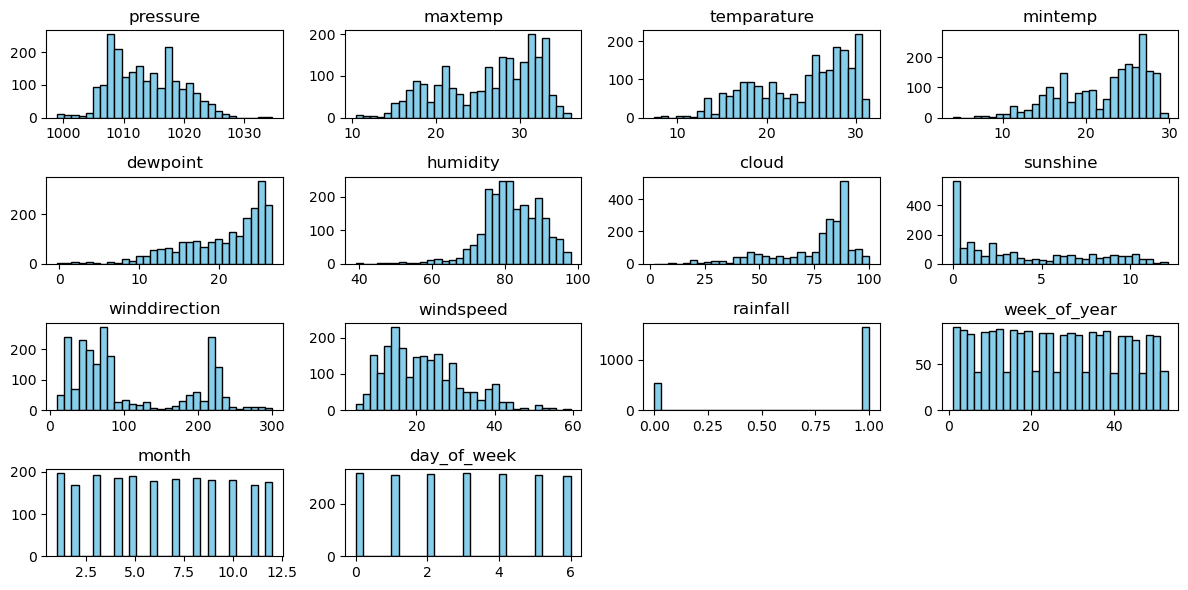

In [11]:
#drow histogram plot for all columns
plt.figure(figsize=(12, 6))
train.drop(["id","day"],axis=1).hist(bins=30, figsize=(12, 6), color='skyblue', edgecolor='black', grid=False)
plt.tight_layout()
plt.show()


### Histogram Analysis

This section provides insights into the distribution of numerical features in the dataset.

**Questions Addressed:**

1.  **What is the overall shape of each feature's distribution?** (e.g., normal, skewed, bimodal, uniform)
2.  **Are there any outliers or unusual patterns?**
3.  **Are the features roughly symmetrically distributed, or are they skewed?**
4.  **Are there multiple modes in the data?**
5.  **What is the range of values for each feature?**
6.  **Are there any features with a large number of zero values?**
7.  **How do the train and test distributions compare?** (If applicable)


**Observations:**

* **pressure:** Roughly symmetrical, slightly right-skewed.
* **maxtemp:** Left-skewed, suggesting a higher concentration of warmer temperatures.
* **temparature:** Bimodal, with peaks around 15 and 25.
* **mintemp:** Left-skewed, similar to maxtemp.
* **dewpoint:** Right-skewed, with a concentration of lower dew points.
* **humidity:** Bimodal, with peaks around 70 and 90.
* **cloud:** Right-skewed, with a high concentration of low cloud cover.
* **sunshine:** Highly right-skewed, with a significant number of days with low sunshine.
* **winddirection:** Bimodal, with peaks around 0-50 and 200-300.
* **windspeed:** Right-skewed, with a concentration of lower wind speeds.
* **rainfall:** Extremely right-skewed, with a very high concentration of zero or near-zero rainfall.

**Potential Implications:**

* **Skewed Distributions:** Features like dewpoint, cloud, sunshine, windspeed, and rainfall may benefit from log or other power transformations.
* **Bimodal Distributions:** Temperature and humidity might require feature engineering to capture the different modes (e.g., creating binary features based on the modes).
* **Outliers:** Pressure may have a few low outliers that should be examined.
* **Zero Values:** Rainfall has a very high concentration of zero values, which might be handled by creating a binary "rain" feature or using a log transform with an offset.



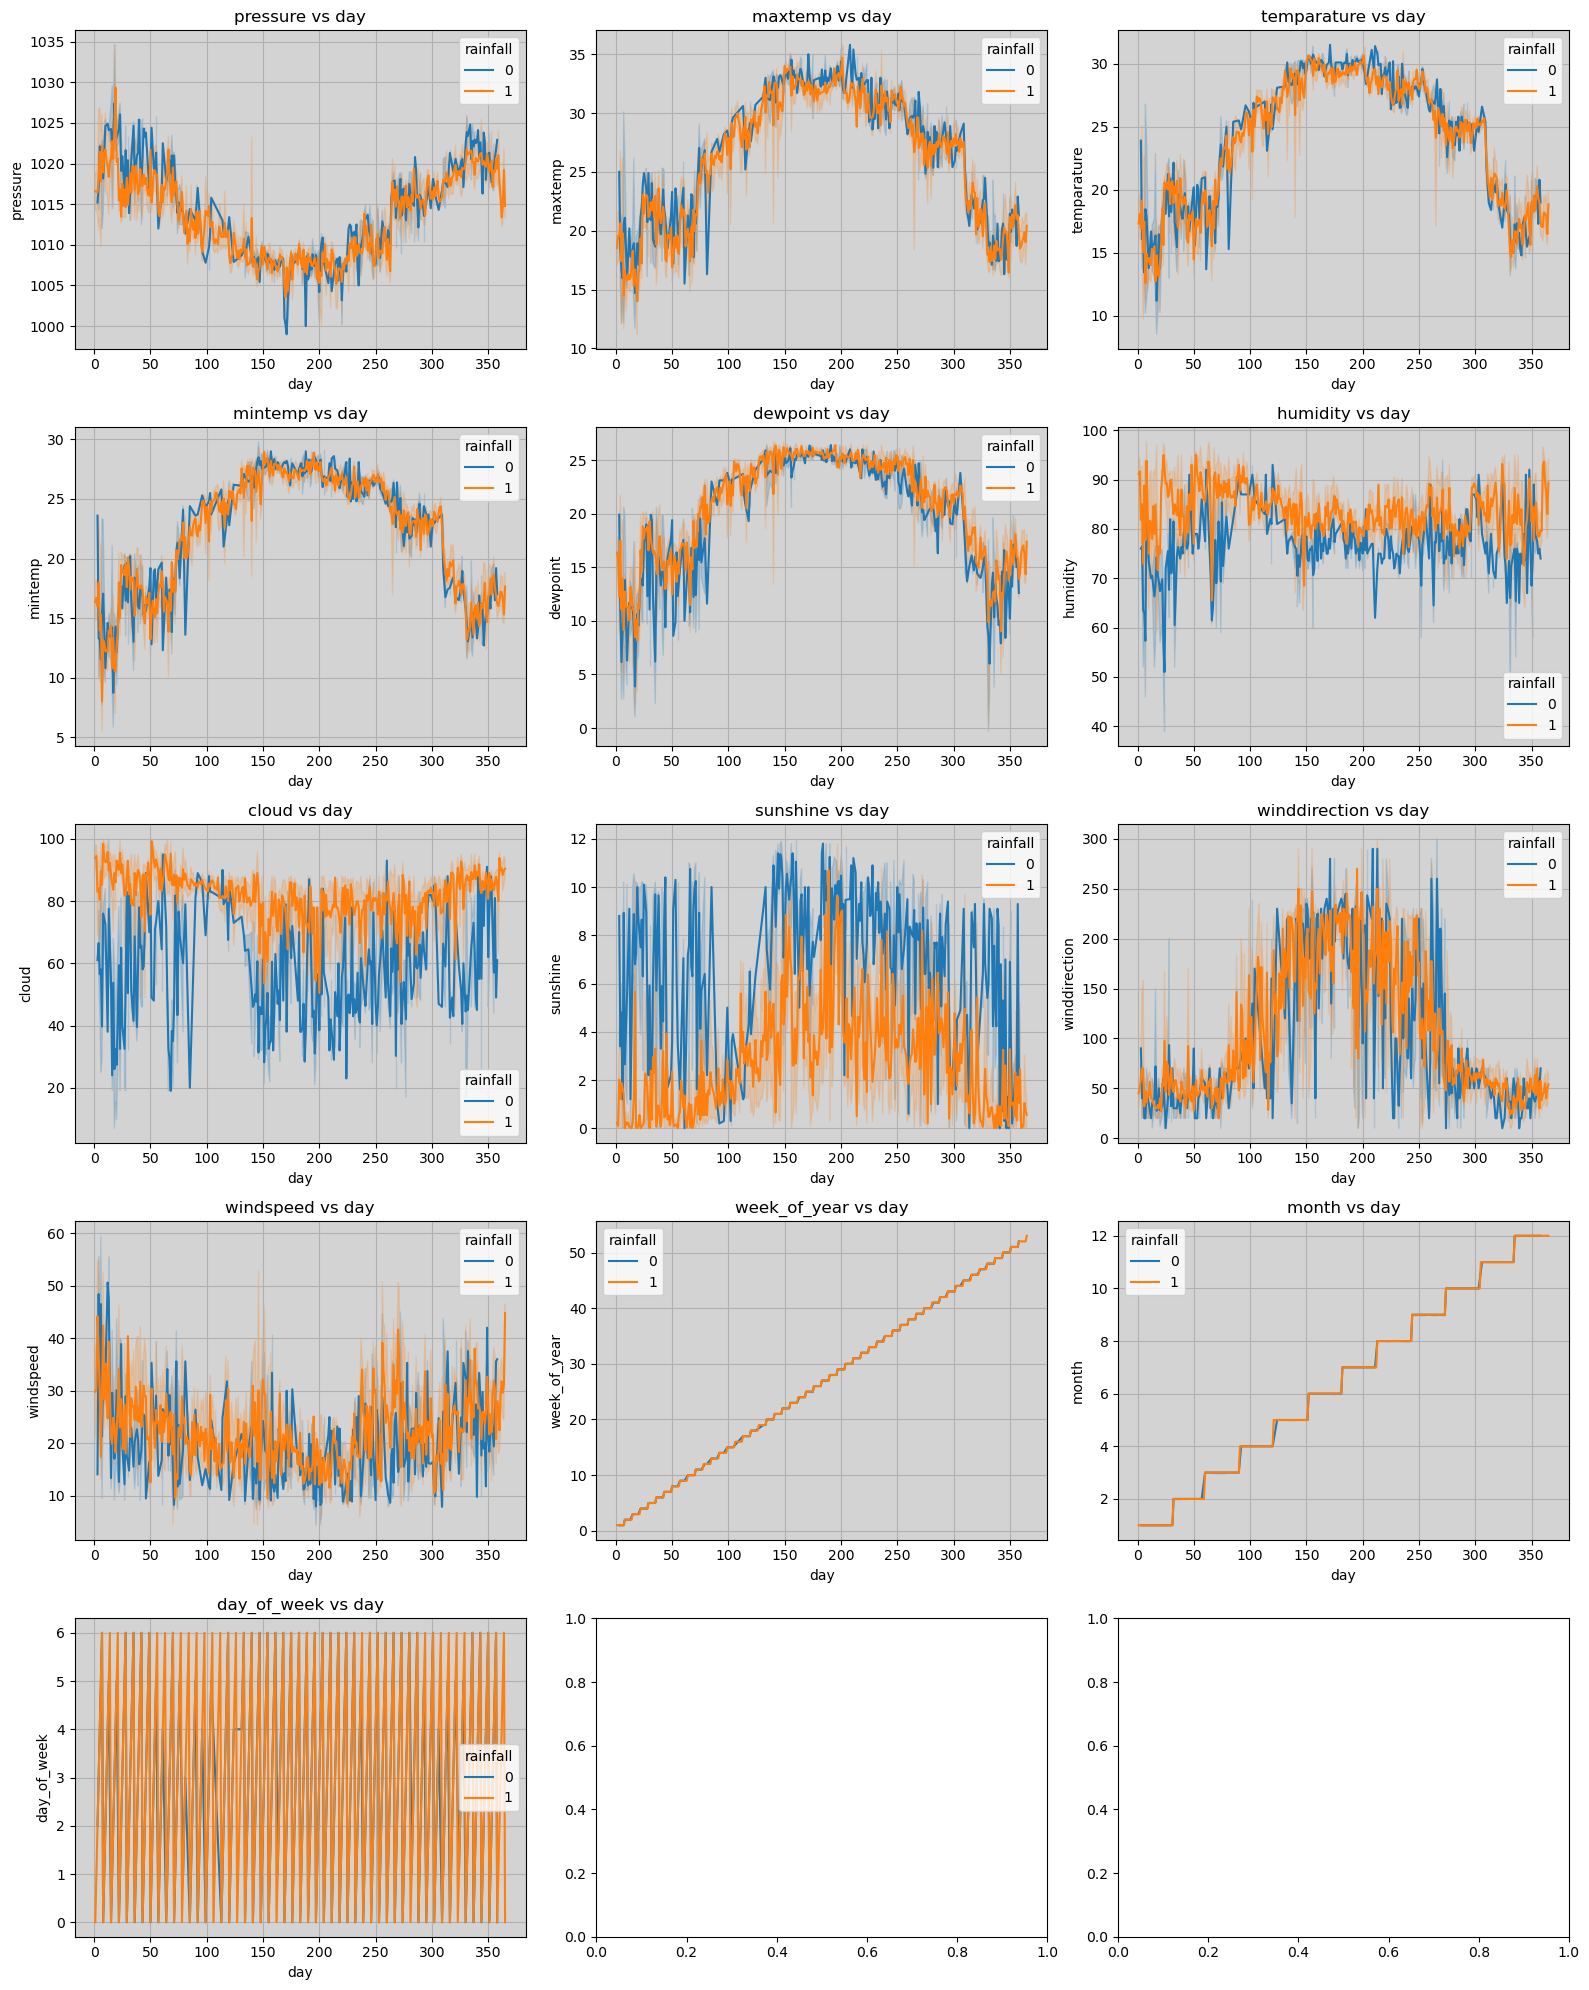

In [12]:
# Assuming 'target' is the name of the target column
features = train.drop(columns=['id', 'day', 'rainfall']).columns
flen=len(features)
fig, axes = plt.subplots(flen//3+1, 3, figsize=(16, flen//3*5)) # 3 columns per row
axes = axes.flatten()
for i , features in enumerate(features):
    sns.lineplot(x='day', y=features,hue='rainfall', data=train, ax=axes[i])
    axes[i].set_title(f'{features} vs day')
    axes[i].set_xlabel('day')
    axes[i].set_ylabel(features)
    axes[i].legend(title='rainfall')
    axes[i].grid(True)
    axes[i].set_facecolor('lightgrey')
for j in range(i+1,flen):
        fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

# Interpretation of Meteorological Data Graphs

The provided image contains a series of six line graphs and three scatter plots, comparing various meteorological variables against the day of the year (ranging from 0 to 350, likely representing a year). The variables analyzed include pressure, maximum temperature, temperature, minimum temperature, dew point, humidity, cloud cover, sunshine, wind speed, and wind direction. Each graph compares these variables under two conditions: with rainfall (orange line, labeled "rainfall = 1") and without rainfall (blue line, labeled "rainfall = 0").

## Key Observations:

### Line Graphs:
1. **Pressure vs. Day**:
   - Pressure fluctuates between approximately 1000 and 1035 hPa.
   - No significant trend is observed, but periodic drops are noticeable around days 100-150 and 250-300, possibly correlating with rainfall events.

2. **Maximum Temperature vs. Day**:
   - Ranges from about 15°C to 35°C, showing a clear seasonal pattern with a peak around days 150-200 (summer) and a dip around days 300-350 (winter).
   - Rainfall (orange) tends to lower the maximum temperature compared to no rainfall (blue).

3. **Temperature vs. Day**:
   - Follows a seasonal trend with a peak around mid-year and a decline toward the year's end.
   - Rainfall slightly reduces the average temperature.

4. **Minimum Temperature vs. Day**:
   - Ranges from 5°C to 25°C, with a similar seasonal pattern.
   - Rainfall has a less pronounced effect on minimum temperatures compared to maximum temperatures.

5. **Dew Point vs. Day**:
   - Varies between 5°C and 20°C, following a seasonal trend.
   - Rainfall increases the dew point, indicating higher moisture levels.

6. **Humidity vs. Day**:
   - Ranges from 40% to 100%, with higher values during rainy periods (orange).
   - A seasonal trend is less clear, but humidity spikes are more frequent with rainfall.

7. **Cloud vs. Day**:
   - Cloud cover ranges from 20 to 100,with higher values during rainy days, suggesting more cloudiness with rainfall.

8. **Sunshine vs. Day**:
   - Sunshine hours range from 0 to 12 hours, peaking around mid-year and dropping toward the year's end.
   - Rainfall significantly reduces sunshine hours.

9. **Wind Speed vs. Day**:
   - Fluctuates between 10 and 50 units (possibly m/s), with no strong seasonal trend.
   - Rainfall appears to increase wind speed slightly.

10. **Wind Direction vs. Day**:
    - Varies widely (0 to 300 degrees), with no clear seasonal pattern.
    - Rainfall does not seem to significantly alter wind direction.

### Scatter Plots:
- The three scatter plots (sunshine vs. rainfall, wind speed vs. rainfall, wind direction vs. rainfall) show weak or no correlation between these variables and rainfall, as the data points are scattered without a clear trend.

## General Insights:
- The data suggests a strong seasonal influence on temperature-related variables (max temp, min temp, dew point), with a peak in the middle of the year.
- Rainfall consistently affects meteorological conditions, generally increasing humidity, cloud cover, dew point, and wind speed while decreasing temperature and sunshine.
- The lack of strong correlations in the scatter plots indicates that rainfall's impact on sunshine, wind speed, and wind direction might be context-dependent or influenced by other factors not shown here.

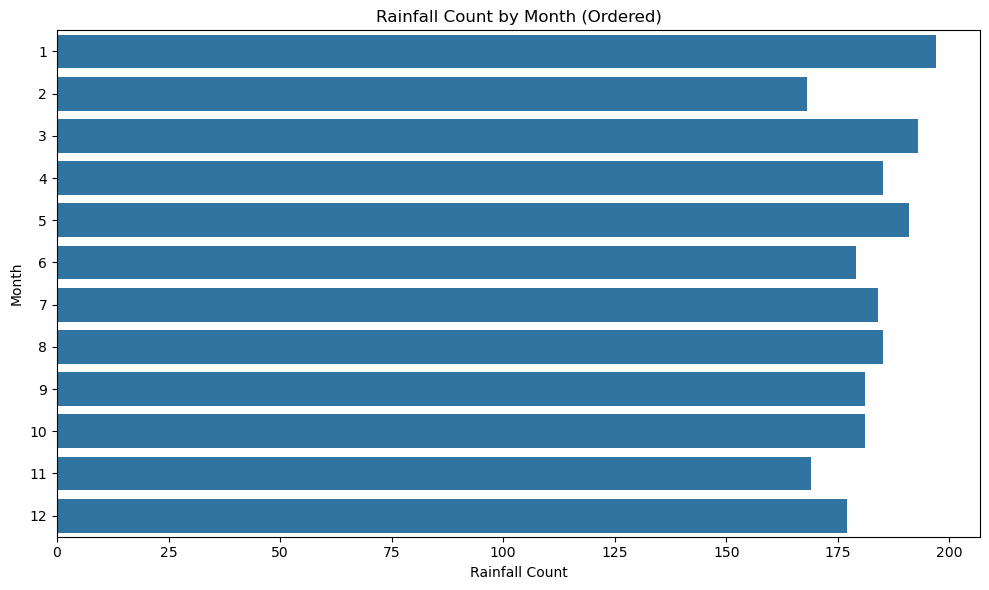

In [13]:
# Count rainfall occurrences per month
rainfall_counts = train.groupby('month')['rainfall'].count().sort_values()

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.barplot(x=rainfall_counts.values, y=rainfall_counts.index, orient='h')

plt.xlabel('Rainfall Count')
plt.ylabel('Month')
plt.title('Rainfall Count by Month (Ordered)')
plt.tight_layout() #prevents labels to be cut off
plt.show()

# Rainfall Analysis by Month

This repository contains an analysis of monthly rainfall data, visualized in a horizontal bar chart.

## Chart Description

The chart displays the rainfall count for each month of the year, ordered from January (1) to December (12). The rainfall count is represented on the horizontal axis, ranging from 0 to 200.


## Key Findings

-   **Consistent Rainfall:** The rainfall is relatively consistent throughout the year.
-   **Peak Months:** January and March exhibit slightly higher rainfall counts.
-   **Lowest Months:** February and November show the lowest rainfall counts.
-   **Range:** All months fall within a rainfall count range of approximately 160 to 200.

## Interpretation

The data suggests a fairly uniform distribution of rainfall across the months, with minor variations. This indicates that the region experiences consistent rainfall throughout the year.

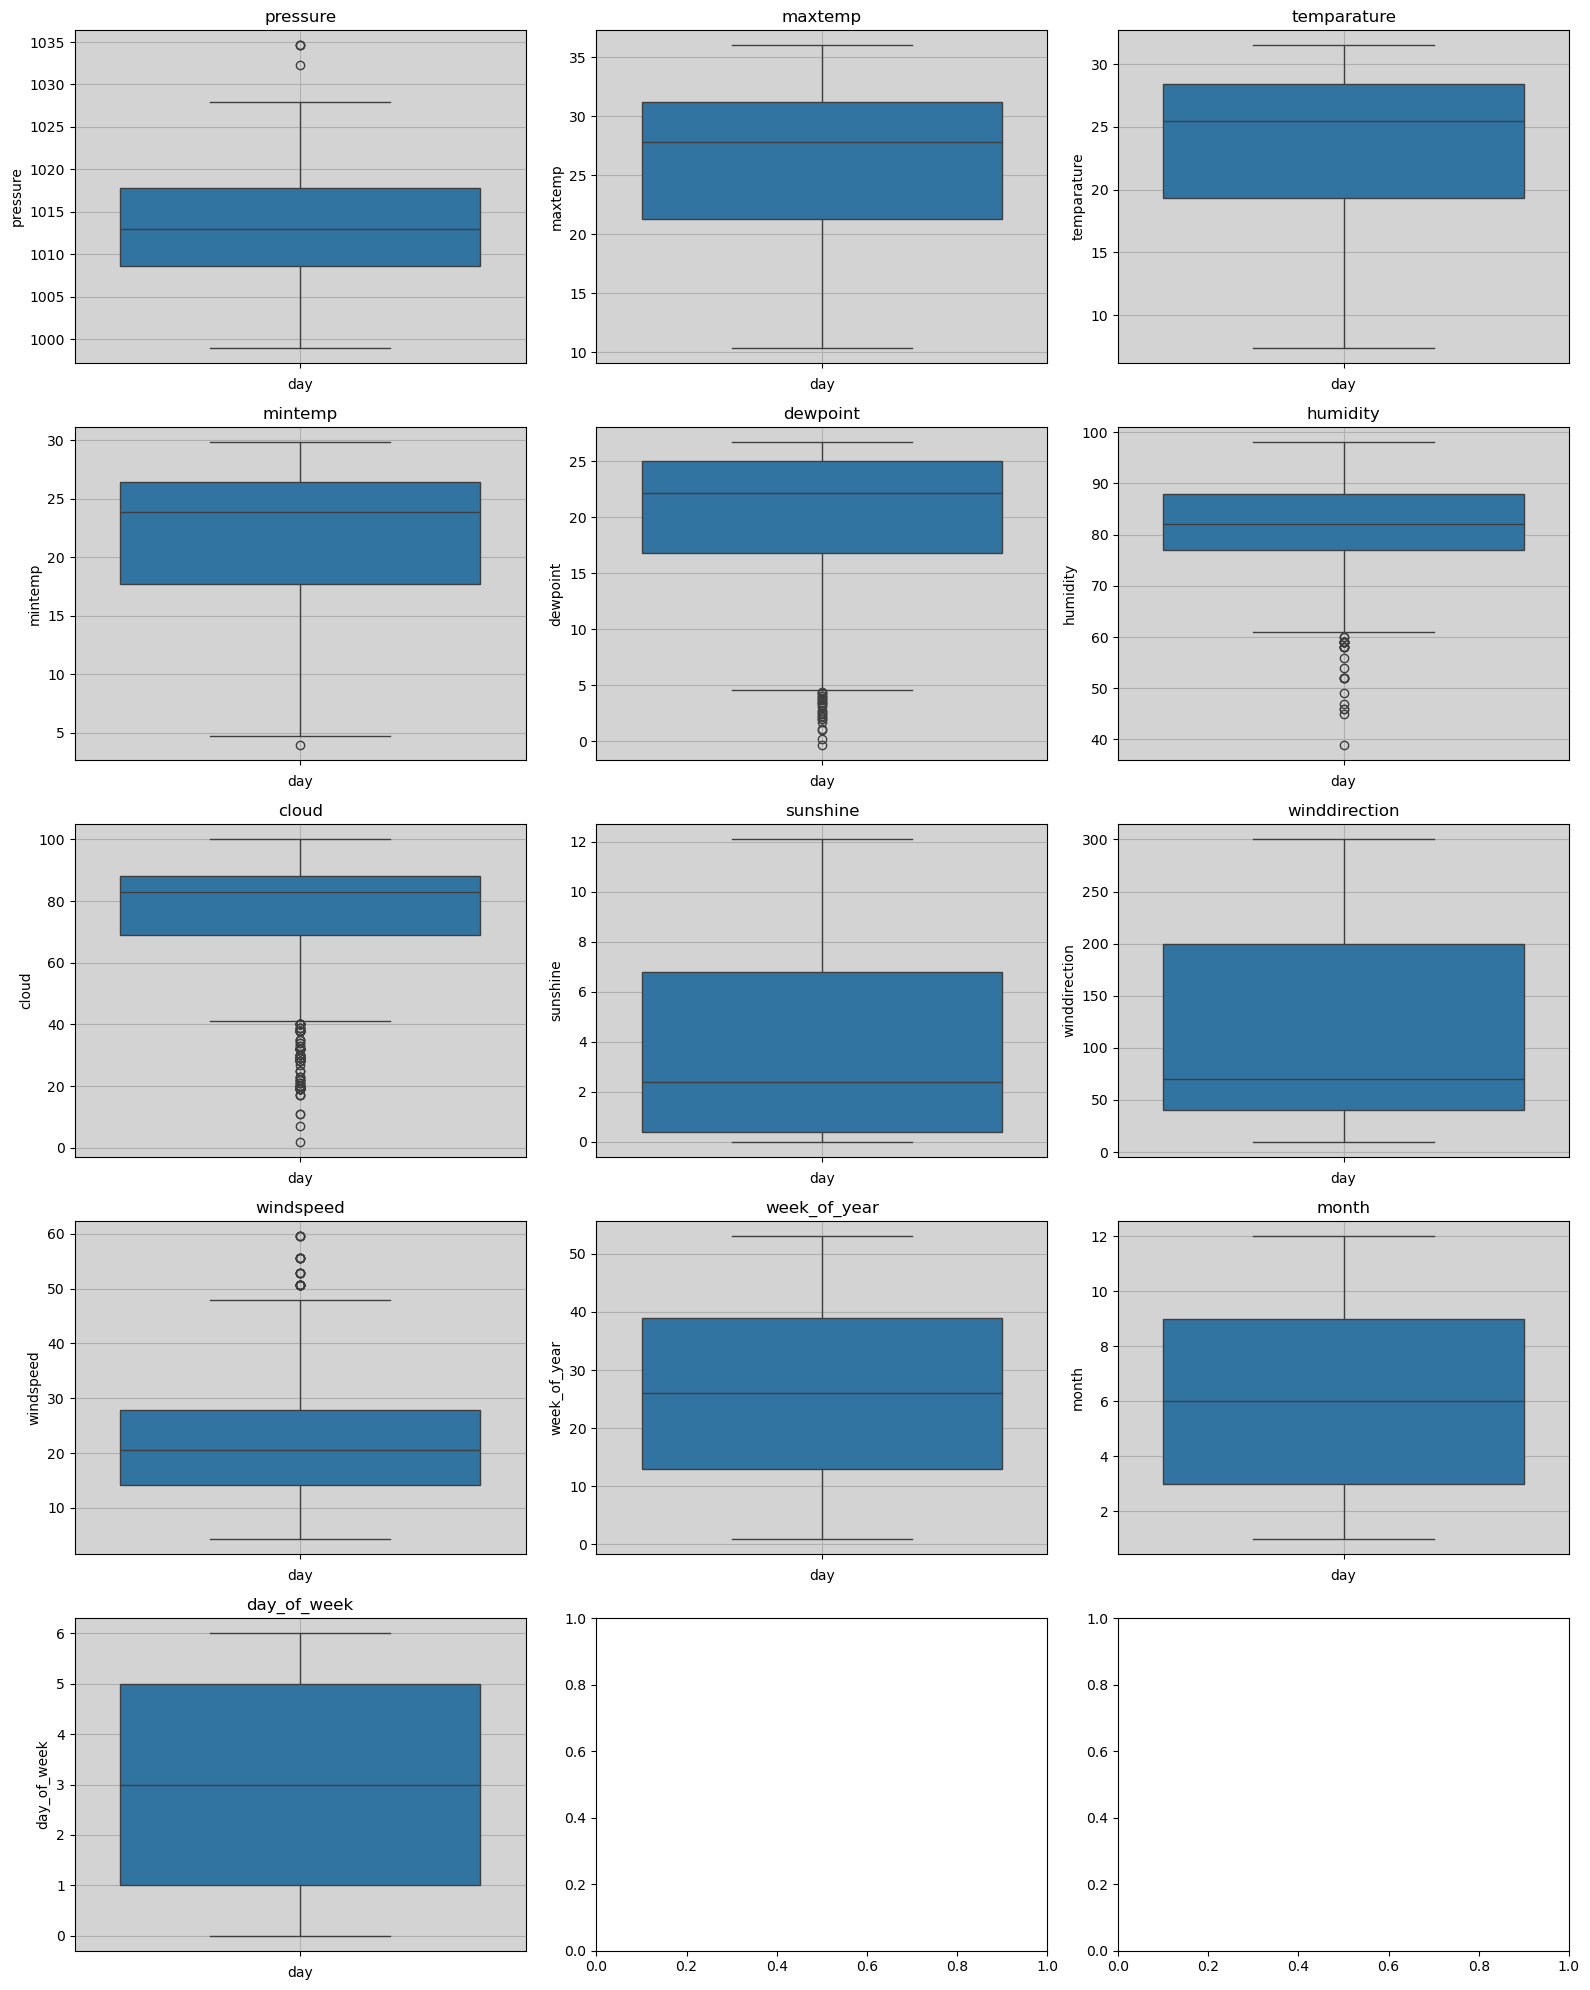

In [14]:
features = train.drop(columns=['id', 'day', 'rainfall']).columns
flen=len(features)
fig, axes = plt.subplots(flen//3+1, 3, figsize=(16, flen//3*5)) # 3 columns per row
axes = axes.flatten()
for i , feature in enumerate(features):
    sns.boxplot(train[feature],ax=axes[i])
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel('day')
    axes[i].set_ylabel(feature)
    axes[i].grid(True)
    axes[i].set_facecolor('lightgrey')
    plt.tight_layout()
plt.show()

# EDA - Boxplots of Meteorological Features vs. Day

This section of the exploratory data analysis (EDA) visualizes the distribution of meteorological features against the "day" variable using boxplots.

## Contents

- [Visual Description](#visual-description)
- [Observations](#observations)

## Visual Description

The boxplots represent the distribution of various meteorological features across different days:

- **Pressure vs. Day**  
  - Range: ~1000 to 1025 hPa  
  - Median: ~1015 hPa  
  - Outliers: A few below 1005 hPa  

- **Max Temp vs. Day**  
  - Range: ~10°C to 35°C  
  - Median: ~25°C  

- **Temperature vs. Day**  
  - Range: ~10°C to 30°C  
  - Median: ~22°C  

- **Min Temp vs. Day**  
  - Range: ~5°C to 25°C  
  - Median: ~15°C  

- **Dewpoint vs. Day**  
  - Range: ~0°C to 25°C  
  - Median: ~15°C  
  - Outliers: Below 5°C  

- **Humidity vs. Day**  
  - Range: ~40% to 100%  
  - Median: ~80%  
  - Outliers: Below 60%  

- **Cloud vs. Day**  
  - Range: ~0 to 100  
  - Median: ~50  
  - Outliers: Below 20  

- **Sunshine vs. Day**  
  - Range: ~0 to 12 hours  
  - Median: ~5 hours  

- **Wind Direction vs. Day**  
  - Range: ~0 to 300 degrees  
  - Median: ~150 degrees  

- **Wind Speed vs. Day of Week**  
  - Range: ~0 to 50  
  - Median: ~30  
  - Outliers: Above 50  

- **Week of Year vs. Day**  
  - Range: ~0 to 50  
  - Median: ~25  

- **Month vs. Day**  
  - Range: 1 to 12  
  - Median: ~6  

- **Day of Week vs. Day**  
  - Range: 0 to 6  
  - Median: ~3  

- **Rainfall vs. Day (Bottom Two Plots)**  
  - Range: 0 to 1 (binary or normalized)  
  - Median: ~0.5  
  - Likely represents rain (1) vs. no rain (0)

## Observations

- **Pressure**: Generally stable around 1015 hPa, with minor variations and a few low-pressure outliers.
- **Temperature (Max, Min, Mean)**: Significant variation, with maximum temperatures reaching 35°C and minimum temperatures dropping to 5°C.
- **Humidity and Dewpoint**: High median humidity (~80%) and dewpoint (~15°C) indicate humid conditions, with some drier outliers.
- **Cloud and Sunshine**: Wide range in cloud cover and sunshine hours suggests variable weather.
- **Wind**: Wind direction and speed vary, with some high wind speed outliers.
- **Temporal Features**: Month, week of year, and day of week are distributed as expected, with medians around the middle of their respective ranges.
- **Rainfall**: The binary-like distribution (0 to 1) suggests the dataset is suited for binary classification (rain vs. no rain), with a balanced occurrence of both outcomes.

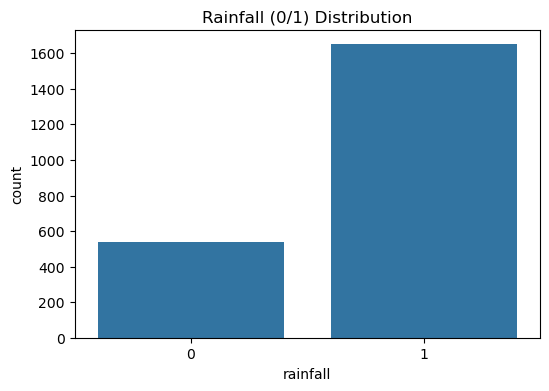

In [15]:
plt.figure(figsize=(6, 4))
sns.countplot(x='rainfall', data=train)
plt.title('Rainfall (0/1) Distribution')
plt.show()

# EDA - Rainfall (0/1) Distribution

This section of the exploratory data analysis (EDA) examines the distribution of the binary rainfall variable in the dataset. The visualization is a histogram showing the count of rainy and non-rainy days.

## Contents

- [Visual Description](#visual-description)
- [Observations](#observations)

## Visual Description

The histogram below represents the distribution of the binary `rainfall` variable:

- **Title**: Rainfall (0/1) Distribution
- **X-axis**: Rainfall (binary values)
  - `0`: No rain
  - `1`: Rain
- **Y-axis**: Count of occurrences
- **Histogram Bars**:
  - `rainfall = 0` (no rain): ~500 instances
  - `rainfall = 1` (rain): ~1500 instances

## Observations

- The dataset contains approximately 2000 data points (500 for no rain + 1500 for rain).
- The distribution is imbalanced:
  - **No Rain (0)**: ~500 instances, accounting for ~25% of the data.
  - **Rain (1)**: ~1500 instances, accounting for ~75% of the data.
- This imbalance indicates that rainy days are significantly more frequent in the dataset compared to non-rainy days.
- For a binary classification task (e.g., predicting rain vs. no rain), this imbalance may lead to a model bias towards predicting rain. To mitigate this, techniques such as oversampling the minority class (no rain), undersampling the majority class (rain), or applying class weights during model training may be necessary.

In [16]:
train.columns

Index(['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'rainfall', 'week_of_year', 'month', 'day_of_week'],
      dtype='object')

In [17]:
train[["month","pressure","temparature","dewpoint","humidity","rainfall"]].groupby('month').agg(
    pressure=('pressure', 'mean'),
    temparature=('temparature', 'mean'),
    dewpoint=('dewpoint', 'mean'),
    humidity=('humidity', 'mean',),
    rainfall=('rainfall', 'mean')
).sort_values(by='rainfall',ascending=False)

,pressure,temparature,dewpoint,humidity,rainfall
month,,,,,
4,1011.802162,25.620000,22.764324,86.129730,0.924324
11,1018.781657,19.987574,16.557396,82.088757,0.834320
3,1015.233161,21.180829,18.327461,85.036269,0.782383
2,1018.092857,18.242262,15.171429,84.089286,0.779762
12,1019.511299,17.693220,14.608475,81.802260,0.779661
10,1015.938674,24.761326,21.116575,81.237569,0.767956
5,1008.703665,28.341885,24.688482,81.900524,0.753927
6,1007.329609,29.621788,25.519553,81.055866,0.737430
8,1008.880000,28.180541,24.535135,80.740541,0.718919


# Observations

- The highest rainfall is observed in Month 4 (0.924324), while the lowest is in Month 7 (0.641304).
- The highest temperature and dewpoint are recorded in Month 7 (29.508152 and 25.266848, respectively), indicating warmer and more humid conditions.
- Pressure values vary from 1007.841304 (Month 7) to 1019.794924 (Month 1), reflecting changes in atmospheric conditions.

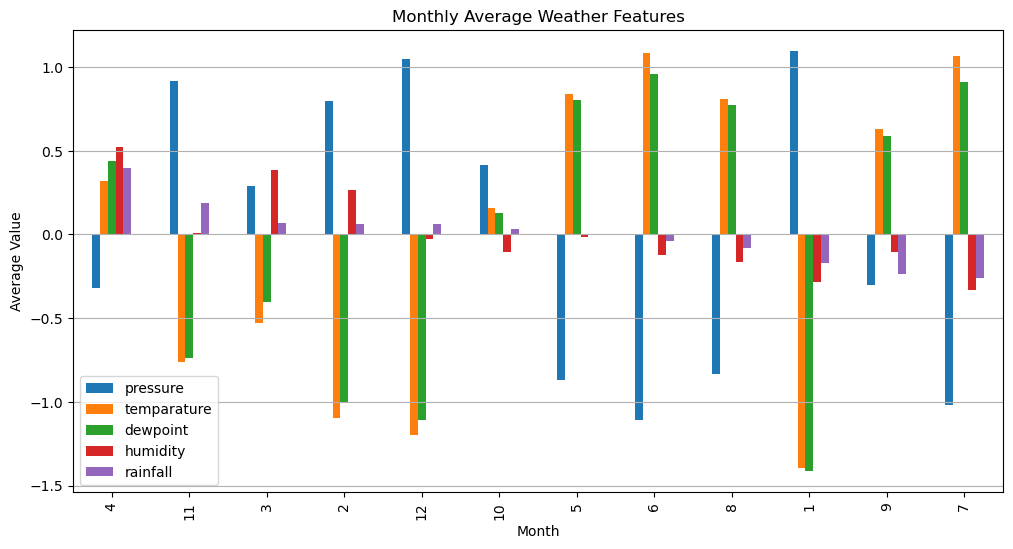

In [18]:
scaler=StandardScaler()
train[["pressure","temparature","dewpoint","humidity","rainfall"]]=scaler.fit_transform(train[["pressure","temparature","dewpoint","humidity","rainfall"]])
train[["month","pressure","temparature","dewpoint","humidity","rainfall"]].groupby('month').agg(
    pressure=('pressure', 'mean'),
    temparature=('temparature', 'mean'),
    dewpoint=('dewpoint', 'mean'),
    humidity=('humidity', 'mean',),
    rainfall=('rainfall', 'mean')
).sort_values(by='rainfall',ascending=False).plot(kind='bar',figsize=(12, 6))
plt.title('Monthly Average Weather Features')
plt.ylabel('Average Value')
plt.xlabel('Month')
plt.grid(axis='y')
plt.show()

# EDA - Monthly Average Weather Features

This section of the exploratory data analysis (EDA) visualizes the normalized average values of weather features (pressure, temperature, dewpoint, humidity, and rainfall) across each month of the year. The visualization is a bar chart showing how these features vary month by month.

## Contents

- [Visual Description](#visual-description)
- [Observations](#observations)

## Visual Description

The bar chart below represents the normalized average values of weather features across each month:

- **Title**: Monthly Average Weather Features
- **X-axis**: Month (1 to 12)
- **Y-axis**: Average value (normalized, ranging from -1.5 to 1.0)
- **Legend**:
  - **Pressure**: Blue
  - **Temperature**: Orange
  - **Dewpoint**: Green
  - **Humidity**: Red
  - **Rainfall**: Purple
- **Monthly Breakdown**:
  - **January (Month 1)**: Pressure (~0.5), temperature (~-1.0), dewpoint (~-1.0), humidity (slightly negative), rainfall (slightly negative).
  - **February (Month 2)**: Pressure (~0.5), temperature (~-1.0), dewpoint (~-1.0), humidity (slightly negative), rainfall (slightly negative).
  - **March (Month 3)**: Pressure (~0.2), temperature (~-0.5), dewpoint (~-0.5), humidity (slightly negative), rainfall (slightly negative).
  - **April (Month 4)**: Pressure (slightly negative), temperature (~0.5), dewpoint (~0.5), humidity (~0.5), rainfall (~0.5).
  - **May (Month 5)**: Pressure (slightly positive), temperature (~0), dewpoint (~0), humidity (~0), rainfall (~0).
  - **June (Month 6)**: Pressure (~-0.5), temperature (~0.8), dewpoint (~0.8), humidity (~0.2), rainfall (~0.2).
  - **July (Month 7)**: Pressure (~-0.5), temperature (~1.0), dewpoint (~1.0), humidity (~0.2), rainfall (~0.2).
  - **August (Month 8)**: Pressure (~-0.5), temperature (~0.8), dewpoint (~0.8), humidity (~0.2), rainfall (~0.2).
  - **September (Month 9)**: Pressure (slightly negative), temperature (~0.5), dewpoint (~0.5), humidity (~0.2), rainfall (~0.2).
  - **October (Month 10)**: Pressure (slightly positive), temperature (~0.5), dewpoint (~0.5), humidity (~0.2), rainfall (~0.2).
  - **November (Month 11)**: Pressure (~0.5), temperature (~0.2), dewpoint (~0.2), humidity (~0.2), rainfall (~0.5).
  - **December (Month 12)**: Pressure (~0.5), temperature (~-1.0), dewpoint (~-1.0), humidity (slightly negative), rainfall (slightly negative).

## Observations

- **Pressure**: Higher in colder months (January, February, November, December) with values around 0.5, and lower in warmer months (June, July, August) with values around -0.5.
- **Temperature and Dewpoint**: Both features peak in July (~1.0) and dip in January and December (~-1.0), showing a strong seasonal trend.
- **Humidity**: Relatively stable, with slight positive values (around 0.2 to 0.5) in most months, peaking in April.
- **Rainfall**: Peaks in April and November (~0.5), with lower values in colder months (January, February, December).
- **Seasonal Trends**: Warmer months (June to August) have higher temperatures and dewpoints, lower pressure, and moderate rainfall, while colder months (December to February) have higher pressure and lower temperatures.

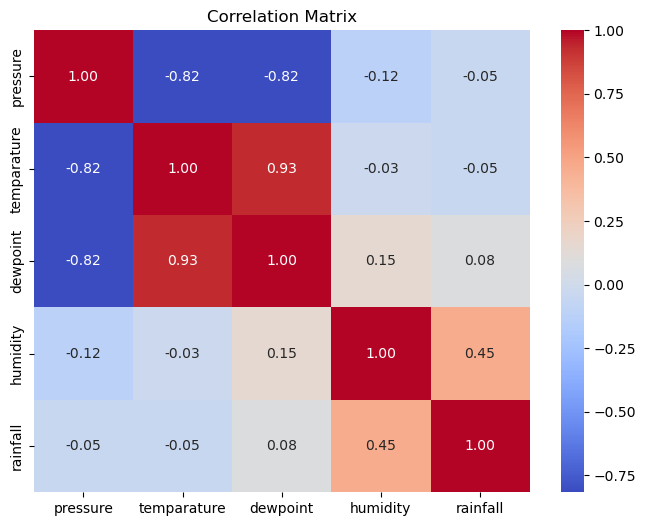

In [19]:
corr_matrix=train[['pressure','temparature','dewpoint','humidity','rainfall']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# EDA - Correlation Matrix of Weather Features

This section of the exploratory data analysis (EDA) examines the relationships between weather features (pressure, temperature, dewpoint, humidity, and rainfall) using a correlation matrix. The matrix visualizes the Pearson correlation coefficients, highlighting the strength and direction of relationships between variables.

## Contents

- [Visual Description](#visual-description)
- [Observations](#observations)

## Visual Description

The correlation matrix below represents the Pearson correlation coefficients between five weather features:

- **Title**: Correlation Matrix
- **Features**: Pressure, Temperature, Dewpoint, Humidity, Rainfall
- **Color Scale**:
  - Blue: Negative correlation (closer to -1.0)
  - Red: Positive correlation (closer to 1.0)
  - White/Neutral: Weak or no correlation (around 0.0)
- **Correlation Values**:
  - **Pressure vs. Pressure**: 1.00
  - **Pressure vs. Temperature**: -0.82
  - **Pressure vs. Dewpoint**: -0.82
  - **Pressure vs. Humidity**: -0.12
  - **Pressure vs. Rainfall**: -0.05
  - **Temperature vs. Temperature**: 1.00
  - **Temperature vs. Dewpoint**: 0.93
  - **Temperature vs. Humidity**: -0.03
  - **Temperature vs. Rainfall**: -0.05
  - **Dewpoint vs. Dewpoint**: 1.00
  - **Dewpoint vs. Humidity**: 0.15
  - **Dewpoint vs. Rainfall**: 0.08
  - **Humidity vs. Humidity**: 1.00
  - **Humidity vs. Rainfall**: 0.45
  - **Rainfall vs. Rainfall**: 1.00

## Observations

- **Strong Correlations**:
  - **Temperature and Dewpoint (0.93)**: A very strong positive correlation indicates that as temperature increases, dewpoint tends to increase as well, reflecting their close meteorological relationship.
  - **Pressure with Temperature and Dewpoint (-0.82 for both)**: Strong negative correlations suggest that higher pressure is associated with lower temperatures and dewpoints, often indicative of cooler, drier conditions.
- **Moderate Correlation**:
  - **Humidity and Rainfall (0.45)**: A moderate positive correlation suggests that higher humidity is associated with a higher likelihood of rainfall, which aligns with meteorological intuition.
- **Weak Correlations**:
  - **Pressure and Humidity (-0.12)**: A weak negative correlation indicates a slight tendency for higher pressure to be associated with lower humidity.
  - **Dewpoint and Humidity (0.15)**: A weak positive correlation shows a mild relationship between these variables.
  - **Rainfall with Temperature (-0.05) and Dewpoint (0.08)**: Very weak correlations suggest that rainfall is not strongly influenced by temperature or dewpoint in this dataset.
- **Implications**:
  - The strong correlation between temperature and dewpoint suggests potential multicollinearity, which may need to be addressed in a predictive model (e.g., by removing one feature or using dimensionality reduction techniques like PCA).
  - The moderate correlation between humidity and rainfall indicates that humidity could be a useful predictor for rainfall.
  - The weak correlations between rainfall and other features (pressure, temperature, dewpoint) suggest that these features alone may not be strong predictors of rainfall, and additional features or transformations might be needed.

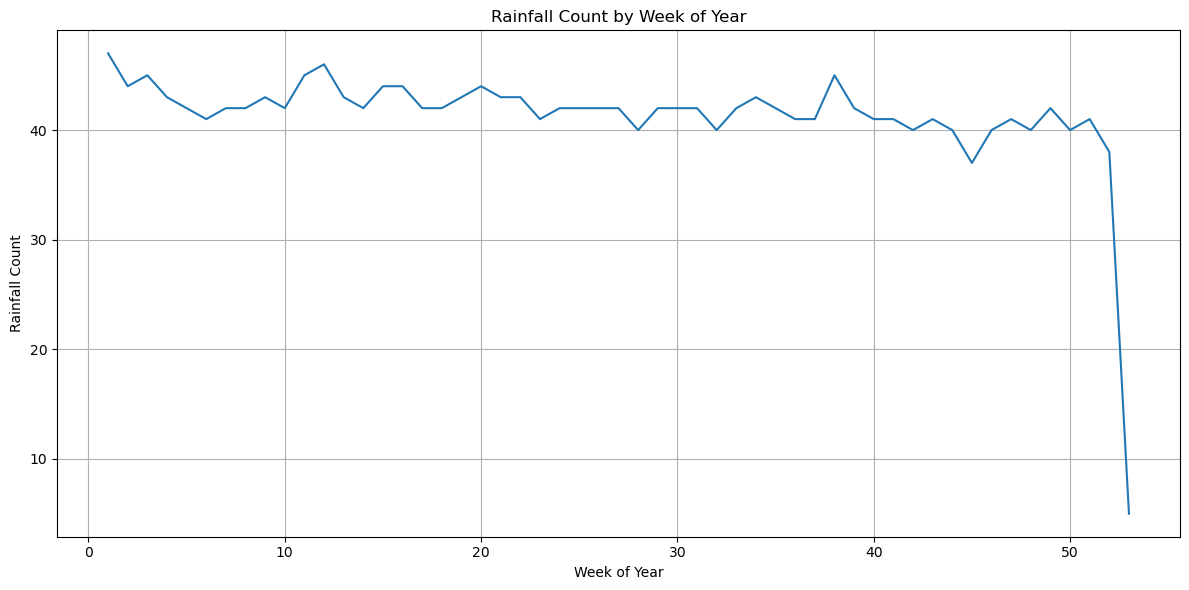

In [20]:
# Count rainfall occurrences per week of the year
rainfall_week_counts = train.groupby('week_of_year')['rainfall'].count().sort_values()

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=rainfall_week_counts.index, y=rainfall_week_counts.values)

plt.xlabel('Week of Year')
plt.ylabel('Rainfall Count')
plt.title('Rainfall Count by Week of Year')
plt.grid(True)
plt.tight_layout()  # Prevents labels from being cut off
plt.show()

# EDA - Rainfall Count by Week of Year

This section of the exploratory data analysis (EDA) visualizes the count of rainfall events across the weeks of a year. The graph provides insights into the seasonal patterns of rainfall, which can be valuable for weather prediction models.

## Contents

- [Visual Description](#visual-description)
- [Observations](#observations)

## Visual Description

The line graph below represents the rainfall count by week of year:

- **Title**: Rainfall Count by Week of Year
- **X-axis**: Week of Year (1 to 52)
- **Y-axis**: Rainfall Count (0 to 50)
- **Data Trend**:
  - Starts at ~40-45 in weeks 1-5.
  - Fluctuates with peaks around weeks 10, 20, and 35-40 (~45).
  - Generally hovers between 30 and 45 from weeks 5-45.
  - Declines sharply after week 45, dropping below 10 by week 50.

## Observations

- **Seasonal Pattern**: The graph indicates a seasonal trend, with higher rainfall counts in the earlier and middle parts of the year (weeks 1-40) and a significant decrease towards the end (weeks 45-52).
- **Peak Rainfall**: Highest counts occur around weeks 10, 20, and 35-40, suggesting possible rainy seasons or periods of higher precipitation.
- **Decline**: A sharp decline after week 45 points to a dry season or period with minimal rainfall towards the year's end.
- **Stability**: The rainfall count remains relatively stable between 30 and 45 for most of the year (weeks 5-45), despite fluctuations.
- **Implications**: This pattern can aid in rainfall prediction, with the end of the year indicating lower rainfall likelihood. Further analysis could correlate this with other weather features like temperature or humidity.

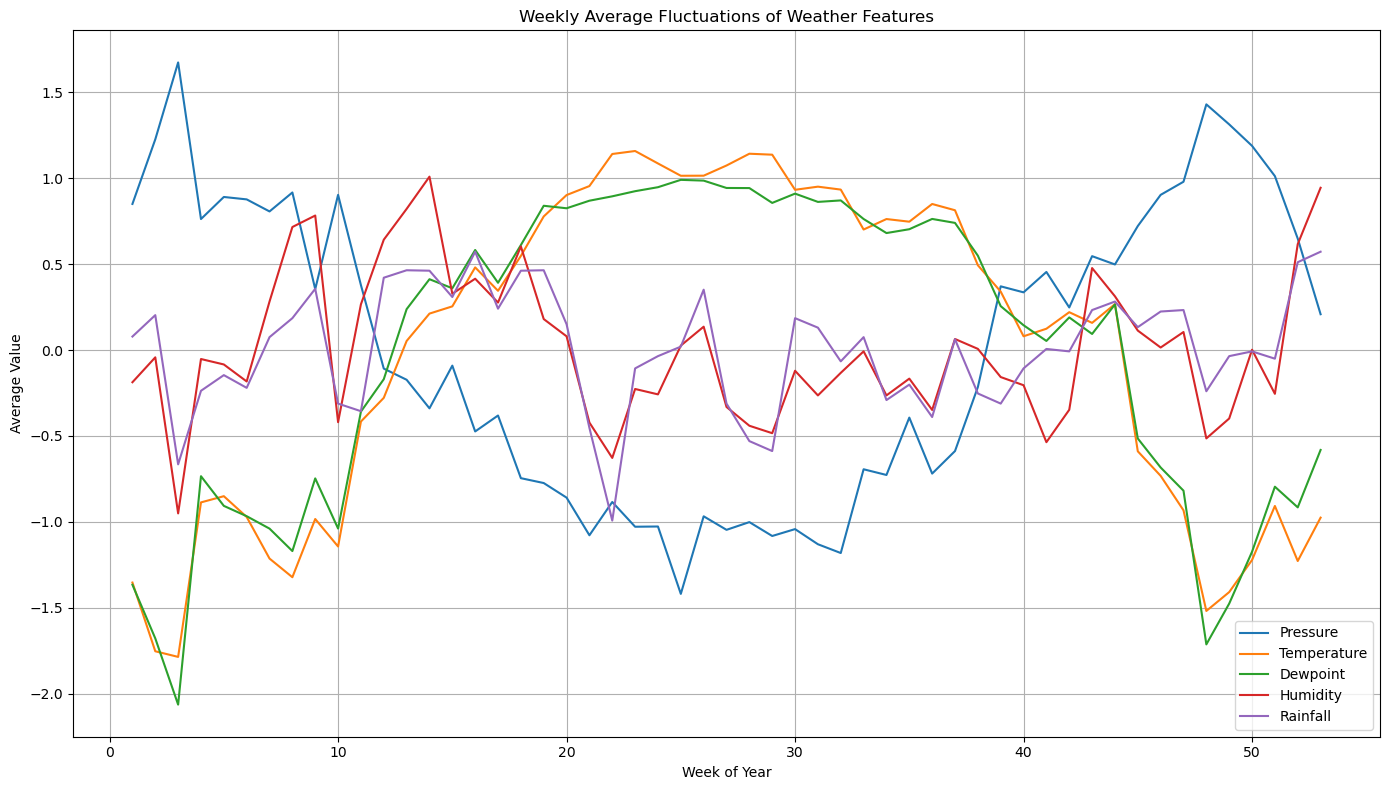

In [21]:
# Calculate weekly averages for the selected features
weekly_avg = train.groupby('week_of_year')[['pressure', 'temparature', 'dewpoint', 'humidity', 'rainfall']].mean().reset_index()

# Plot the data
plt.figure(figsize=(14, 8))
sns.lineplot(data=weekly_avg, x='week_of_year', y='pressure', label='Pressure')
sns.lineplot(data=weekly_avg, x='week_of_year', y='temparature', label='Temperature')
sns.lineplot(data=weekly_avg, x='week_of_year', y='dewpoint', label='Dewpoint')
sns.lineplot(data=weekly_avg, x='week_of_year', y='humidity', label='Humidity')
sns.lineplot(data=weekly_avg, x='week_of_year', y='rainfall', label='Rainfall')

plt.title('Weekly Average Fluctuations of Weather Features')
plt.xlabel('Week of Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Interpretation of the Weather Features Graph  

## Overview  
This line graph represents the **weekly average fluctuations** of key weather features throughout the year. The parameters include:  

- **Pressure (hPa)** - A dominant feature fluctuating around **1000 hPa**.  
- **Temperature (°C)** - Shows slight seasonal variations.  
- **Dewpoint (°C)** - Closely follows the temperature trend.  
- **Humidity (%)** - Generally stays between **80-100%** with minor fluctuations.  
- **Rainfall (mm)** - Low values with occasional peaks, indicating seasonal rainfall.  

## Key Observations  
- **Pressure** is relatively stable across all weeks.  
- **Temperature and Dewpoint** show expected seasonal changes.  
- **Humidity** remains consistently high with slight variations.  
- **Rainfall** shows periodic increases, suggesting wet and dry seasons.  

## Conclusion  
This visualization is useful for analyzing seasonal trends and understanding climate behavior over time.